## Network Analysis

#### Creating the Bipartite Graph

We'll first create a bipartite graph where one set of nodes represents influencers and the other represents brands:

In [2]:
import json
import numpy as np
import networkx as nx
from tqdm import tqdm

In [3]:
# Load relationship extraction result file
with open('/content/update-relationship.json', 'r') as f:
    final_kol_brand_relationships = json.load(f)

In [41]:
# Create a bipartite graph from the extracted relationships
B = nx.Graph()
influencers = set()
brands = set()

print("Building bipartite graph...")
for result in tqdm(final_kol_brand_relationships, desc="Processing Results"):
    # Check if 'edges' exists in the result
    if 'edges' not in result:
        continue  # Skip this entry if it doesn't have 'edges'

    for edge in result['edges']:
        influencer = edge.get('from')
        brand = edge.get('to')
        type_ = edge.get('type')
        if not influencer or not brand or not type_:
            continue  # Skip if either influencer or brand is missing
        influencers.add(influencer)
        brands.add(brand)
        B.add_edge(influencer, brand)

print(f"\nNumber of influencers: {len(influencers)}")
print(f"Number of brands: {len(brands)}")
print(f"Number of edges in the bipartite graph: {B.number_of_edges()}")

# Project onto the brand layer to get brand-to-brand relationships
print("\nProjecting bipartite graph onto brand layer...")
brand_graph = nx.bipartite.weighted_projected_graph(B, brands)
print(f"Number of nodes in brand graph: {brand_graph.number_of_nodes()}")
print(f"Number of edges in brand graph: {brand_graph.number_of_edges()}")

# Project onto the kol layer to get kol-to-kol relationships
print("\nProjecting bipartite graph onto kol layer...")
kol_graph = nx.bipartite.weighted_projected_graph(B, influencers)
print(f"Number of nodes in kol graph: {kol_graph.number_of_nodes()}")
print(f"Number of edges in kol graph: {kol_graph.number_of_edges()}")



Building bipartite graph...


Processing Results: 100%|██████████| 821/821 [00:00<00:00, 45770.84it/s]


Number of influencers: 814
Number of brands: 751
Number of edges in the bipartite graph: 1009

Projecting bipartite graph onto brand layer...
Number of nodes in brand graph: 816
Number of edges in brand graph: 669

Projecting bipartite graph onto kol layer...
Number of nodes in kol graph: 890
Number of edges in kol graph: 678


First we started from creating a bipartite graph  connecting influencers to brands based on the relationships in our json file. Each influencer-brand pair is added as an edge in graph, building a network of connections.
In our B graph we have:
814 influencers
751 brands
1009 edges - there are 1009 instances where an influencer is associated with a brand.

Then we projected another graph where brands are connected if they share at least one influencer. In this graph we have 816 brands and 669 connections exist between these brands.

When exploring the kol graph, we have 890 influencers and 678 connections among these influencers.

### Brand Graph

In [31]:
# Calculate centralities on the brand graph
print("\nCalculating centrality measures...")
degree_centrality = nx.degree_centrality(brand_graph)
betweenness_centrality = nx.betweenness_centrality(brand_graph)
eigenvector_centrality = nx.eigenvector_centrality(brand_graph, max_iter=1000)

# Combine centralities into a single metric for ranking
combined_centrality = {
    node: (degree_centrality.get(node, 0) +
           betweenness_centrality.get(node, 0) +
           eigenvector_centrality.get(node, 0)) / 3
    for node in brand_graph.nodes()
}

# Sort brands by combined centrality
sorted_brands = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)

# Select top N brands for visualization
N = 20  # Adjust this as needed
top_brands = [brand for brand, _ in sorted_brands[:N]]

# Print top brands with their combined centrality scores
print("\nTop brands by combined centrality:")
for brand, centrality_score in sorted_brands[:N]:
    print(f"{brand}: {centrality_score:.4f}")



Calculating centrality measures...

Top brands by combined centrality:
Apple: 0.0898
Target: 0.0872
Charlotte Tilbury: 0.0829
Wrangler: 0.0829
Brooklinen: 0.0823
Brand Name: 0.0816
Marshall: 0.0816
Wayfair: 0.0816
Melin: 0.0816
Fjällräven: 0.0816
Kiehl’s: 0.0816
Vornado: 0.0816
Avocado Green Mattress: 0.0816
Firsgrill: 0.0816
Honeywell: 0.0816
Bend This: 0.0816
YETI: 0.0816
Logitech: 0.0816
The New York Post: 0.0816
Electric Scooter Brand: 0.0816


#### Edge Trimming

In [37]:
# Define the trim_edges function with percentile threshold
def trim_edges(graph, percentile=20):
    """
    Removes edges from the graph that have weights below the specified percentile.

    Parameters:
    - graph (networkx.Graph): The input graph with weighted edges.
    - percentile (float): The percentile threshold below which edges will be removed.

    Returns:
    - networkx.Graph: The trimmed graph.
    """
    if not graph.edges(data=True):
        print("The graph has no edges to trim.")
        return graph
    weights = [data['weight'] for u, v, data in graph.edges(data=True)]
    threshold = np.percentile(weights, percentile)
    print(f"Trimming edges with weights below the {percentile}th percentile (threshold: {threshold:.4f})")

    trimmed_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        if data['weight'] >= threshold:
            trimmed_graph.add_edge(u, v, **data)

    trimmed_graph.add_nodes_from(graph.nodes(data=True))
    return trimmed_graph


In [38]:
# Trim edges with lowest weights before plotting
percentile = 10
print("\nTrimming low-weight edges...")
trimmed_brand_graph = trim_edges(brand_graph, percentile=percentile)
print(f"Number of nodes after trimming: {trimmed_brand_graph.number_of_nodes()}")
print(f"Number of edges after trimming: {trimmed_brand_graph.number_of_edges()}")


Trimming low-weight edges...
Trimming edges with weights below the 10th percentile (threshold: 1.0000)
Number of nodes after trimming: 816
Number of edges after trimming: 669


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
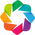

In [26]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
import matplotlib.pyplot as plt

# Setting the default figure size a bit larger
defaults = dict(width=750, height=750, padding=0.1,
                xaxis=None, yaxis=None)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

### Graph Projection


Preparing visualization...


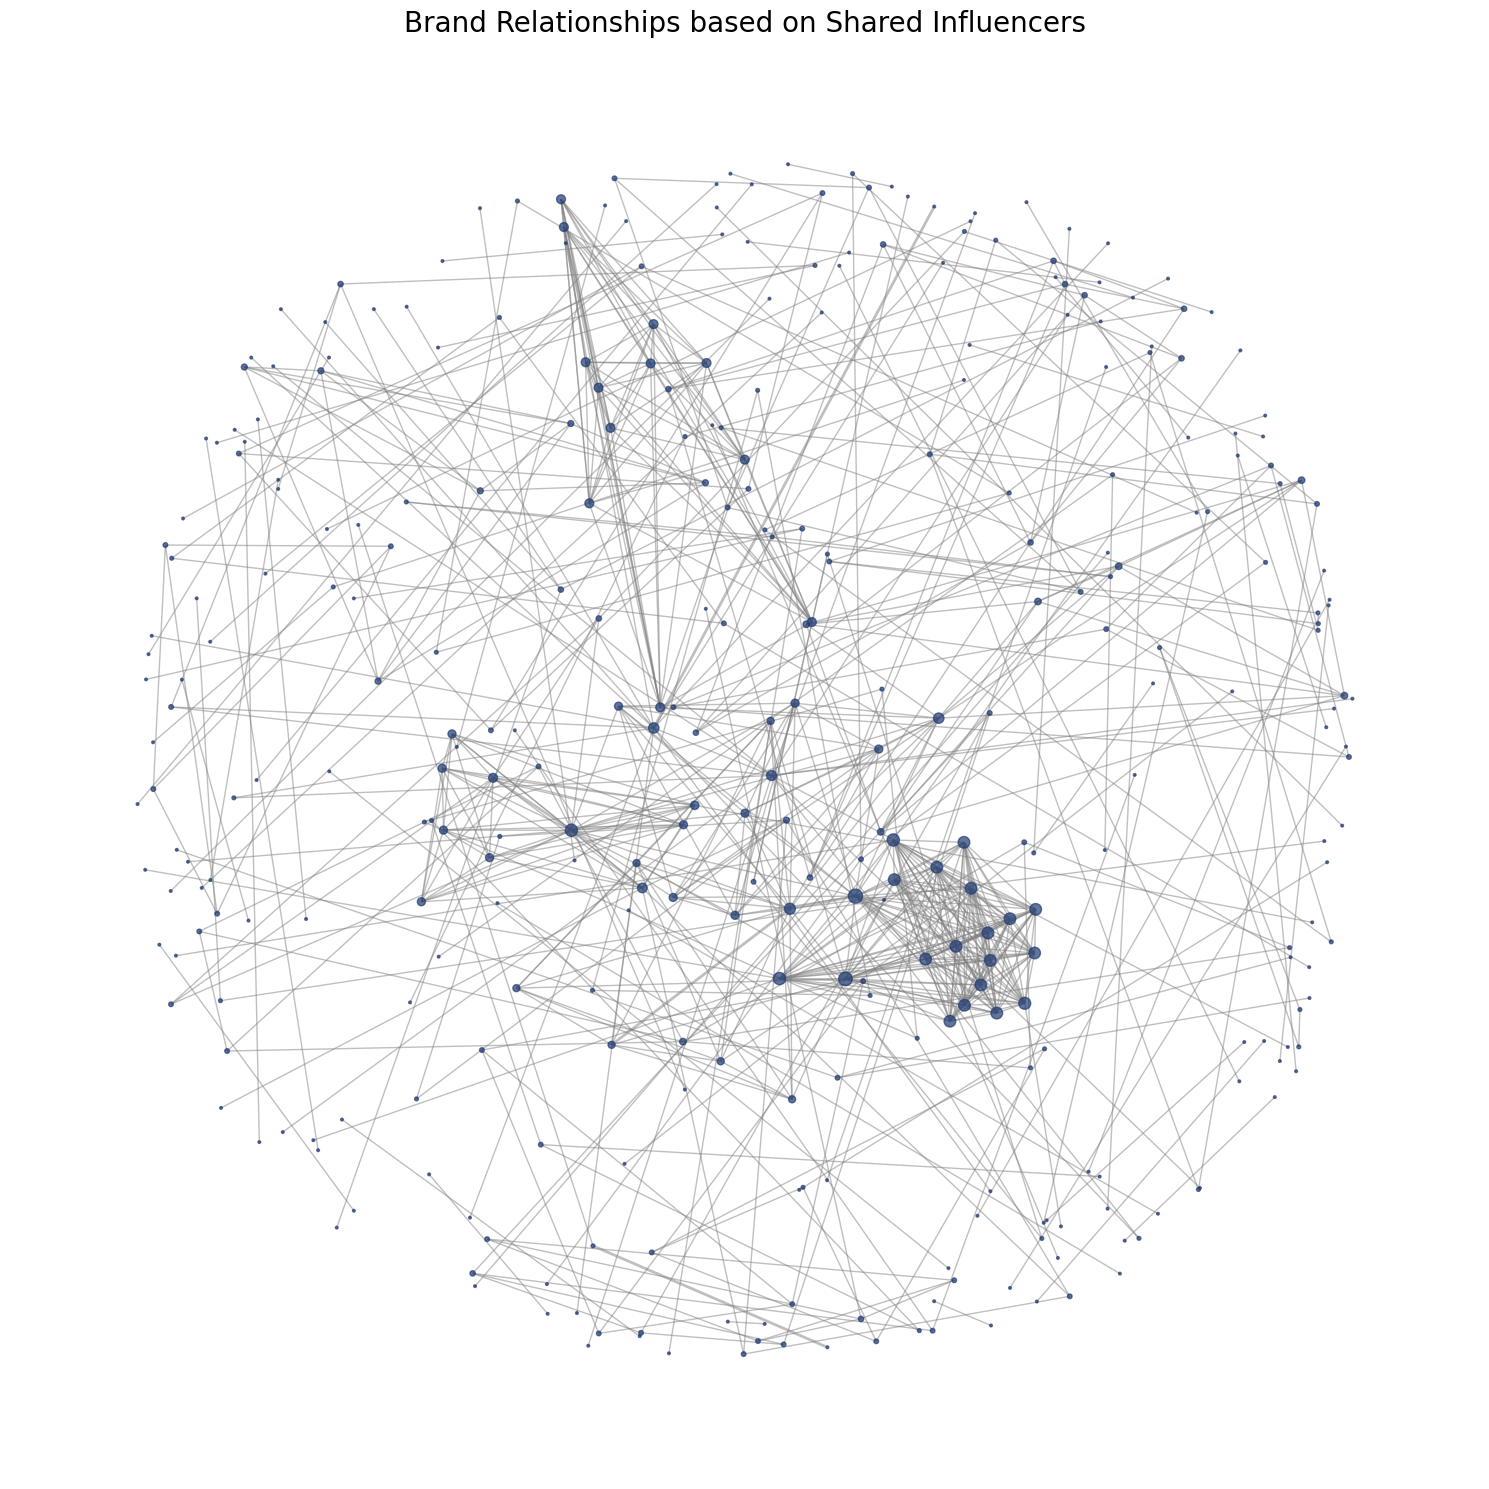

In [40]:
# Prepare for visualization of trimmed_brand_graph
print("\nPreparing visualization...")
pos = nx.spring_layout(trimmed_brand_graph, k=0.5, iterations=50)  # Adjust layout parameters as needed

# Node sizes based on degree centrality (adjust or change metric if desired)
degree_centrality = nx.degree_centrality(trimmed_brand_graph)
sizes = [degree_centrality[node] * 3000 for node in trimmed_brand_graph.nodes()]  # Scale node sizes

# Visualize the network
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
nx.draw_networkx_nodes(trimmed_brand_graph, pos, node_size=sizes, alpha=0.7, node_color='#1f3b73')
nx.draw_networkx_edges(
    trimmed_brand_graph, pos, alpha=0.5,
    width=[data['weight'] for _, _, data in trimmed_brand_graph.edges(data=True)],
    edge_color='gray'
)
nx.draw_networkx_labels(trimmed_brand_graph, pos, font_size=10, labels={})

plt.title("Brand Relationships based on Shared Influencers", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('trimmed_brand_network.png', dpi=300, bbox_inches='tight')
plt.show()


### Looking at the most centralized part of the brand graph

In [39]:
# Create and save a layout.
G_layout = nx.layout.fruchterman_reingold_layout(trimmed_brand_graph)
g_plot = hv.Graph.from_networkx(brand_graph, G_layout).opts(tools=['hover'],
                                                  edge_color='weight', cmap=plt.cm.Set2,
                                                  legend_position='right')

show(hv.render(g_plot))

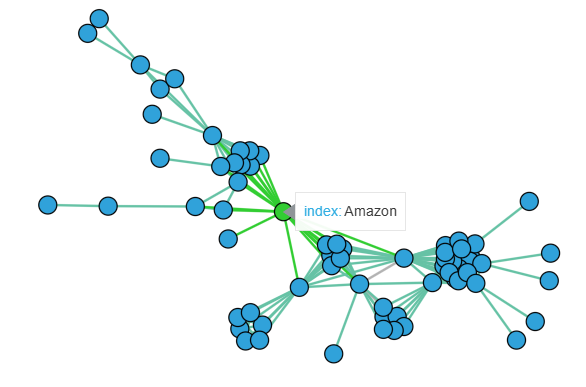                           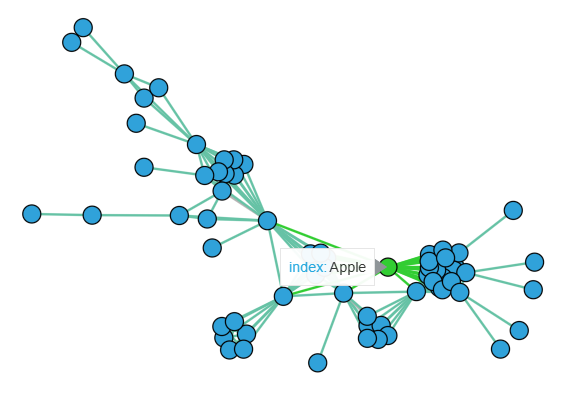

### KOL/Influencer Graph

In [42]:
# Calculate centralities on the kol graph
print("\nCalculating centrality measures...")
degree_centrality = nx.degree_centrality(kol_graph)
betweenness_centrality = nx.betweenness_centrality(kol_graph)
eigenvector_centrality = nx.eigenvector_centrality(kol_graph, max_iter=1000)

# Combine centralities into a single metric for ranking
combined_centrality = {
    node: (degree_centrality.get(node, 0) +
           betweenness_centrality.get(node, 0) +
           eigenvector_centrality.get(node, 0)) / 3
    for node in kol_graph.nodes()
}

# Sort influencers by centrality scores in descending order
sorted_kols = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)

# Select top N influencers
N = 20
top_kols = [influencer for influencer, _ in sorted_kols[:N]]

# Print top influencers with their centrality scores
for influencer, score in sorted_kols[:N]:
    print(f"{influencer}: {score}")


Calculating centrality measures...
Forbes Technology Council: 0.10759126972548368
Hannah Murphy: 0.1027058260082761
influencer_name: 0.09923740827578638
Marques Brownlee: 0.09527987386523469
Reddit users: 0.09375832278118314
Hanna: 0.09375832278118314
Meta: 0.09375832278118314
Raymond Kurzweil: 0.09375832278118314
Rick Grimaldi: 0.09375832278118314
Billie Eilish: 0.09375832278118314
Ron Amadeo: 0.09375832278118314
Geoffrey Hinton: 0.09375832278118314
Laura Mae Martin: 0.09375832278118312
Post Wanted by the New York Post: 0.037162500372355606
Todd Haselton: 0.02407719502683746
Steve Kovach: 0.02407719502683746
Kif Leswing: 0.024077195026837455
Sabrina Carpenter: 0.015754125052054122
Imperial: 0.013342988509783632
TikTok user: 0.01303156784968352


In [44]:
# Because the weight of most edges are 1, so we simplify the network by trimming the marginal nodes based on combined centrality.

def trim_nodes(graph, percentile=95):
    """
    Removes nodes from the graph based on a combined centrality measure.

    Parameters:
    - graph (networkx.Graph): The input graph.
    - percentile (float): The percentile threshold below which nodes will be removed.

    Returns:
    - networkx.Graph: The trimmed graph.
    """
    if not graph.nodes():
        print("The graph has no nodes to trim.")
        return graph

    # Calculate threshold based on combined centrality
    centrality_values = list(combined_centrality.values())
    threshold = np.percentile(centrality_values, percentile)
    print(f"Trimming nodes with combined centrality below the {percentile}th percentile (threshold: {threshold:.4f})")

    # Create a copy of the graph and remove nodes below the centrality threshold
    trimmed_graph = graph.copy()
    nodes_to_remove = [node for node, centrality in combined_centrality.items() if centrality < threshold]
    trimmed_graph.remove_nodes_from(nodes_to_remove)

    return trimmed_graph

In [45]:
# We use only top 5% nodes with highest centrality, ensuring they are the most important in the network
print("\nTrimming low-weight edges...")
trimmed_kol_graph = trim_nodes(kol_graph, percentile=95)
print(f"Number of nodes after trimming: {trimmed_kol_graph.number_of_nodes()}")
print(f"Number of edges after trimming: {trimmed_kol_graph.number_of_edges()}")


Trimming low-weight edges...
Trimming nodes with combined centrality below the 95th percentile (threshold: 0.0028)
Number of nodes after trimming: 47
Number of edges after trimming: 150


After the trimming process, 47 nodes with 150 edges are remained. We observe that the **density** of the network, calculated as the ratio of actual edges to possible edges, has decreased compared to the original network. This decline in density indicates that the network has become more **sparse** following the removal of nodes with lower centrality.

Now we can see a more fully connected network to one where only the most central, influential connections are preserved.


Preparing visualization...


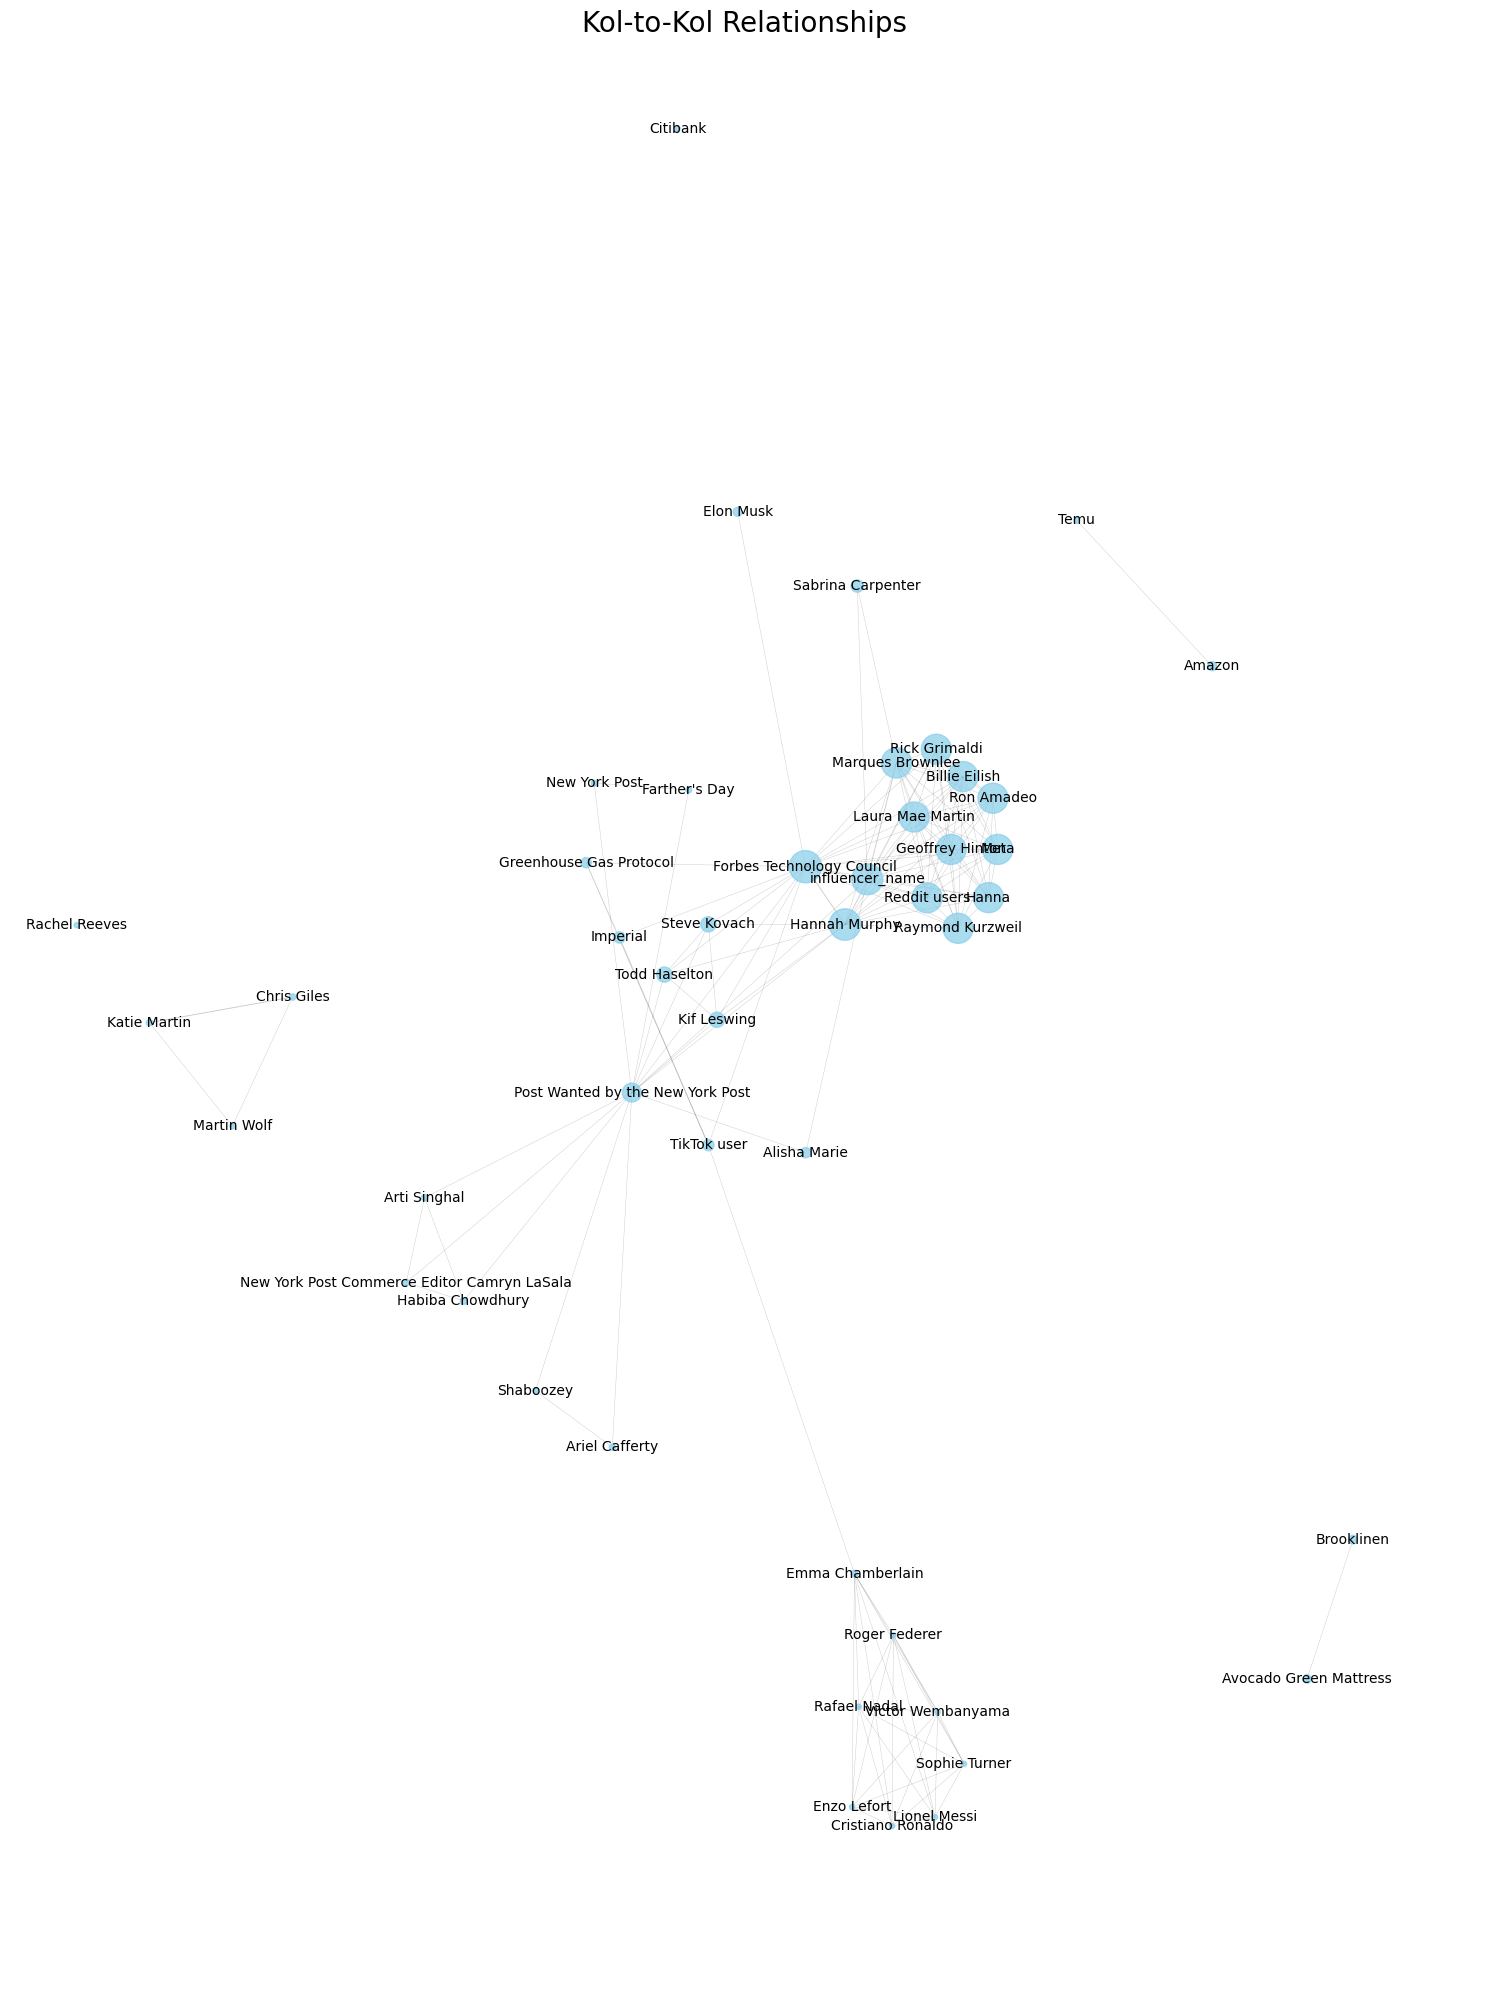

In [47]:
# Plotting
print("\nPreparing visualization...")
pos = nx.spring_layout(trimmed_kol_graph, k=0.3, iterations=35)  # Adjust layout parameters as needed
sizes = [combined_centrality[node] * 5000 for node in trimmed_kol_graph.nodes()]  # Scale node sizes
labels = {node: node for node in trimmed_kol_graph.nodes()}

# Draw the network
plt.figure(figsize=(15, 20))  # Adjust figure size as needed
nx.draw_networkx_nodes(trimmed_kol_graph, pos, node_size=sizes, alpha=0.7, node_color='skyblue')
nx.draw_networkx_edges(
    trimmed_kol_graph, pos, alpha=0.2,
    width=[data['weight']/3 for _, _, data in trimmed_kol_graph.edges(data=True)],
    edge_color='black'
)
nx.draw_networkx_labels(trimmed_kol_graph, pos, labels, font_size=10)

plt.title("Kol-to-Kol Relationships", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('kol_network.png', dpi=300, bbox_inches='tight')
plt.show()

In this plot we can see the "core" subnetwork with the central nodes such as "Hannah Murphy", "Marques Brownee", "Geoffrey Hinton" and "Laura Mae Martin". They all have stable relationships to paticular brands in Technology.

Meanwhile, there are also some fragmentation or isolated clusters, such as the cluster centered with "Sophie Turner", which is influencers with brands in Fashion and Apparel. This is common when low-centrality nodes, which often act as bridges between communities, are removed.